<h1>Simple LSTM with Monthly Dataset</h1>

In [41]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')

In [42]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [43]:
chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
king_all_copy, king_data= load_data(ismael_path)
print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [44]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [45]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [46]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [47]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [48]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [49]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))

(60, 2)


In [50]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def month_to_year(month_preds):
    month_preds = month_preds[5:]
    print(len(month_preds))
    year_preds = []
    for i in range(12, len(month_preds), 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [51]:
def create_LSTM_model(x_train, y_train, x_test, y_test): 
    '''
    Create LSTM model trained on X_train and Y_train
    and make predictions on the X_test data
    '''
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(5, input_shape=(x_train.shape[1],1)))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
    history_LSTM = LSTM_model.fit(x_train, y_train, epochs=1000, batch_size=150, verbose=2)
    
    train_preds = LSTM_model.predict(x_train)
    test_preds = LSTM_model.predict(x_test)
    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    return LSTM_model, test_preds, train_preds, y_test, y_train, history_LSTM

In [52]:
# running LSTM
LSTM_model, test_preds_LSTM, train_preds_LSTM, y_test, y_train, history_LSTM = create_LSTM_model(x_train, y_train, x_test, y_test)

Epoch 1/1000
7/7 - 1s - loss: 0.0110
Epoch 2/1000
7/7 - 0s - loss: 0.0098
Epoch 3/1000
7/7 - 0s - loss: 0.0092
Epoch 4/1000
7/7 - 0s - loss: 0.0090
Epoch 5/1000
7/7 - 0s - loss: 0.0091
Epoch 6/1000
7/7 - 0s - loss: 0.0091
Epoch 7/1000
7/7 - 0s - loss: 0.0090
Epoch 8/1000
7/7 - 0s - loss: 0.0090
Epoch 9/1000
7/7 - 0s - loss: 0.0090
Epoch 10/1000
7/7 - 0s - loss: 0.0090
Epoch 11/1000
7/7 - 0s - loss: 0.0090
Epoch 12/1000
7/7 - 0s - loss: 0.0090
Epoch 13/1000
7/7 - 0s - loss: 0.0090
Epoch 14/1000
7/7 - 0s - loss: 0.0090
Epoch 15/1000
7/7 - 0s - loss: 0.0090
Epoch 16/1000
7/7 - 0s - loss: 0.0090
Epoch 17/1000
7/7 - 0s - loss: 0.0090
Epoch 18/1000
7/7 - 0s - loss: 0.0090
Epoch 19/1000
7/7 - 0s - loss: 0.0090
Epoch 20/1000
7/7 - 0s - loss: 0.0089
Epoch 21/1000
7/7 - 0s - loss: 0.0089
Epoch 22/1000
7/7 - 0s - loss: 0.0089
Epoch 23/1000
7/7 - 0s - loss: 0.0089
Epoch 24/1000
7/7 - 0s - loss: 0.0089
Epoch 25/1000
7/7 - 0s - loss: 0.0089
Epoch 26/1000
7/7 - 0s - loss: 0.0089
Epoch 27/1000
7/7 - 0

Epoch 214/1000
7/7 - 0s - loss: 0.0085
Epoch 215/1000
7/7 - 0s - loss: 0.0085
Epoch 216/1000
7/7 - 0s - loss: 0.0085
Epoch 217/1000
7/7 - 0s - loss: 0.0085
Epoch 218/1000
7/7 - 0s - loss: 0.0085
Epoch 219/1000
7/7 - 0s - loss: 0.0085
Epoch 220/1000
7/7 - 0s - loss: 0.0085
Epoch 221/1000
7/7 - 0s - loss: 0.0085
Epoch 222/1000
7/7 - 0s - loss: 0.0085
Epoch 223/1000
7/7 - 0s - loss: 0.0085
Epoch 224/1000
7/7 - 0s - loss: 0.0085
Epoch 225/1000
7/7 - 0s - loss: 0.0085
Epoch 226/1000
7/7 - 0s - loss: 0.0085
Epoch 227/1000
7/7 - 0s - loss: 0.0085
Epoch 228/1000
7/7 - 0s - loss: 0.0085
Epoch 229/1000
7/7 - 0s - loss: 0.0085
Epoch 230/1000
7/7 - 0s - loss: 0.0085
Epoch 231/1000
7/7 - 0s - loss: 0.0085
Epoch 232/1000
7/7 - 0s - loss: 0.0085
Epoch 233/1000
7/7 - 0s - loss: 0.0085
Epoch 234/1000
7/7 - 0s - loss: 0.0085
Epoch 235/1000
7/7 - 0s - loss: 0.0085
Epoch 236/1000
7/7 - 0s - loss: 0.0084
Epoch 237/1000
7/7 - 0s - loss: 0.0084
Epoch 238/1000
7/7 - 0s - loss: 0.0085
Epoch 239/1000
7/7 - 0s -

Epoch 425/1000
7/7 - 0s - loss: 0.0082
Epoch 426/1000
7/7 - 0s - loss: 0.0082
Epoch 427/1000
7/7 - 0s - loss: 0.0082
Epoch 428/1000
7/7 - 0s - loss: 0.0082
Epoch 429/1000
7/7 - 0s - loss: 0.0083
Epoch 430/1000
7/7 - 0s - loss: 0.0082
Epoch 431/1000
7/7 - 0s - loss: 0.0082
Epoch 432/1000
7/7 - 0s - loss: 0.0083
Epoch 433/1000
7/7 - 0s - loss: 0.0082
Epoch 434/1000
7/7 - 0s - loss: 0.0083
Epoch 435/1000
7/7 - 0s - loss: 0.0082
Epoch 436/1000
7/7 - 0s - loss: 0.0083
Epoch 437/1000
7/7 - 0s - loss: 0.0082
Epoch 438/1000
7/7 - 0s - loss: 0.0082
Epoch 439/1000
7/7 - 0s - loss: 0.0082
Epoch 440/1000
7/7 - 0s - loss: 0.0083
Epoch 441/1000
7/7 - 0s - loss: 0.0082
Epoch 442/1000
7/7 - 0s - loss: 0.0082
Epoch 443/1000
7/7 - 0s - loss: 0.0082
Epoch 444/1000
7/7 - 0s - loss: 0.0082
Epoch 445/1000
7/7 - 0s - loss: 0.0082
Epoch 446/1000
7/7 - 0s - loss: 0.0082
Epoch 447/1000
7/7 - 0s - loss: 0.0082
Epoch 448/1000
7/7 - 0s - loss: 0.0082
Epoch 449/1000
7/7 - 0s - loss: 0.0082
Epoch 450/1000
7/7 - 0s -

7/7 - 0s - loss: 0.0079
Epoch 636/1000
7/7 - 0s - loss: 0.0079
Epoch 637/1000
7/7 - 0s - loss: 0.0079
Epoch 638/1000
7/7 - 0s - loss: 0.0079
Epoch 639/1000
7/7 - 0s - loss: 0.0079
Epoch 640/1000
7/7 - 0s - loss: 0.0078
Epoch 641/1000
7/7 - 0s - loss: 0.0081
Epoch 642/1000
7/7 - 0s - loss: 0.0080
Epoch 643/1000
7/7 - 0s - loss: 0.0079
Epoch 644/1000
7/7 - 0s - loss: 0.0079
Epoch 645/1000
7/7 - 0s - loss: 0.0078
Epoch 646/1000
7/7 - 0s - loss: 0.0078
Epoch 647/1000
7/7 - 0s - loss: 0.0078
Epoch 648/1000
7/7 - 0s - loss: 0.0078
Epoch 649/1000
7/7 - 0s - loss: 0.0078
Epoch 650/1000
7/7 - 0s - loss: 0.0078
Epoch 651/1000
7/7 - 0s - loss: 0.0080
Epoch 652/1000
7/7 - 0s - loss: 0.0079
Epoch 653/1000
7/7 - 0s - loss: 0.0079
Epoch 654/1000
7/7 - 0s - loss: 0.0078
Epoch 655/1000
7/7 - 0s - loss: 0.0078
Epoch 656/1000
7/7 - 0s - loss: 0.0078
Epoch 657/1000
7/7 - 0s - loss: 0.0078
Epoch 658/1000
7/7 - 0s - loss: 0.0079
Epoch 659/1000
7/7 - 0s - loss: 0.0078
Epoch 660/1000
7/7 - 0s - loss: 0.0078
E

Epoch 846/1000
7/7 - 0s - loss: 0.0073
Epoch 847/1000
7/7 - 0s - loss: 0.0074
Epoch 848/1000
7/7 - 0s - loss: 0.0074
Epoch 849/1000
7/7 - 0s - loss: 0.0073
Epoch 850/1000
7/7 - 0s - loss: 0.0073
Epoch 851/1000
7/7 - 0s - loss: 0.0076
Epoch 852/1000
7/7 - 0s - loss: 0.0075
Epoch 853/1000
7/7 - 0s - loss: 0.0074
Epoch 854/1000
7/7 - 0s - loss: 0.0073
Epoch 855/1000
7/7 - 0s - loss: 0.0073
Epoch 856/1000
7/7 - 0s - loss: 0.0074
Epoch 857/1000
7/7 - 0s - loss: 0.0073
Epoch 858/1000
7/7 - 0s - loss: 0.0073
Epoch 859/1000
7/7 - 0s - loss: 0.0073
Epoch 860/1000
7/7 - 0s - loss: 0.0073
Epoch 861/1000
7/7 - 0s - loss: 0.0073
Epoch 862/1000
7/7 - 0s - loss: 0.0073
Epoch 863/1000
7/7 - 0s - loss: 0.0074
Epoch 864/1000
7/7 - 0s - loss: 0.0073
Epoch 865/1000
7/7 - 0s - loss: 0.0073
Epoch 866/1000
7/7 - 0s - loss: 0.0074
Epoch 867/1000
7/7 - 0s - loss: 0.0073
Epoch 868/1000
7/7 - 0s - loss: 0.0073
Epoch 869/1000
7/7 - 0s - loss: 0.0073
Epoch 870/1000
7/7 - 0s - loss: 0.0073
Epoch 871/1000
7/7 - 0s -

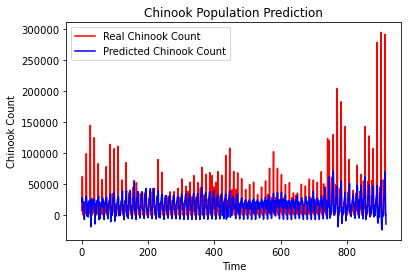

The root mean squared error is 24708.75384775695.


In [53]:
plot_predictions(y_train, train_preds_LSTM)
return_rmse(y_train, train_preds_LSTM)

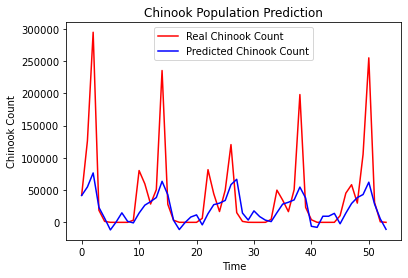

The root mean squared error is 55689.75246047483.


In [54]:
plot_predictions(y_test, test_preds_LSTM)
return_rmse(y_test, test_preds_LSTM)

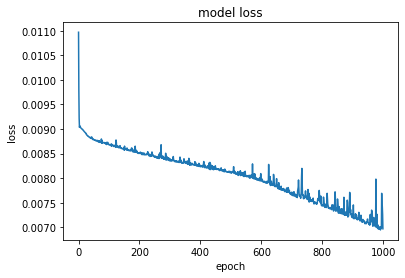

In [55]:
plot_loss(history_LSTM)

In [56]:
# global var for baseline
y_test_year = month_to_year(y_test)

49


In [57]:
y_test_year = month_to_year(y_test)
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
y_test_year = y_test_year.astype(np.int64)

49


In [58]:
# Comparing RMSE to curr Forecasting methods to LSTM
LSTM_test_year = month_to_year(test_preds_LSTM)
LSTM_test_year = LSTM_test_year.astype(np.int64)

49


In [59]:
LSTM_test_year

,Count
0,225430
1,248594
2,230231
3,243977


In [60]:
# test RMSE with baseline and LSTM
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, LSTM_test_year)

The root mean squared error is 115854.5707848853.
The root mean squared error is 215181.95938960588.
